In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import osmnx as ox


import matplotlib.pylab as plt
%matplotlib inline




## Datarensning


In [ ]:
# This will handle loading and cleaning the Excel data for brukare and medarbetare.
def load_data(file_path):
    """
    Load Excel data and return a dictionary of dataframes.
    """
    # Load the Excel file from the given file path
    excel_data = pd.ExcelFile(file_path)
    
    # Parse the sheets into separate dataframes
    data = {
        'brukare': excel_data.parse('Individer, brukare', header=1),
        'medarbetare': excel_data.parse('Medarbetare', header=2)
    }

    return data


def clean_data(brukare_df, medarbetare_df):
    """
    Clean and structure brukare and medarbetare data for analysis.
    """
    # Rename 'Unnamed: 0' to 'Individ' for brukare_df
    brukare_df.rename(columns={'Unnamed: 0': 'Individ'}, inplace=True)

    # Rename 'Unnamed: 0' to 'Medarbetare' for medarbetare_df
    medarbetare_df.rename(columns={'Unnamed: 0': 'Medarbetare'}, inplace=True)

    # Remove brukare with missing or invalid 'Individ' or 'Adress'
    brukare_df = brukare_df.dropna(subset=['Individ', 'Adress']).copy()
    brukare_df = brukare_df[brukare_df['Individ'] != '-']  # Remove rows where 'Individ' is '-'
    brukare_df = brukare_df[brukare_df['Adress'] != '-']  # Remove rows where 'Adress' is '-'
    
    # Fill missing values in other columns with placeholder '-'
    brukare_df.fillna('-', inplace=True)
    medarbetare_df.fillna('-', inplace=True)

    # Convert relevant columns to boolean
    #brukare_df['Kräver körkort'] = brukare_df['Kräver körkort'].apply(lambda x: x == 'Ja')
    #medarbetare_df['Körkort'] = medarbetare_df['Körkort'].apply(lambda x: x == 'Ja')

    columns_medarbetare = list(medarbetare_df)

    brukare_df['Kräver körkort'] = brukare_df['Kräver körkort'].apply(lambda x: x == 'Ja')
    brukare_df['Behöver insulin'] = brukare_df['Behöver insulin'].apply(lambda x: x == 'Ja')
    brukare_df['Röker'] = brukare_df['Röker'].apply(lambda x: x == 'Ja')
    brukare_df['Har hund'] = brukare_df['Har hund'].apply(lambda x: x == 'Ja')
    brukare_df['Har katt'] = brukare_df['Har katt'].apply(lambda x: x == 'Ja')
    brukare_df['Kräver >18'] = brukare_df['Kräver >18'].apply(lambda x: x == 'Ja')



    for column in columns_medarbetare[1:]:
        medarbetare_df[column] = medarbetare_df[column].apply(lambda x: x == 'Ja')


    return brukare_df, medarbetare_df


data = load_data("Studentuppgift fiktiv planering.xlsx")

brukare_df, medarbetare_df = clean_data(data["brukare"], data["medarbetare"])

display(brukare_df)
display(medarbetare_df)

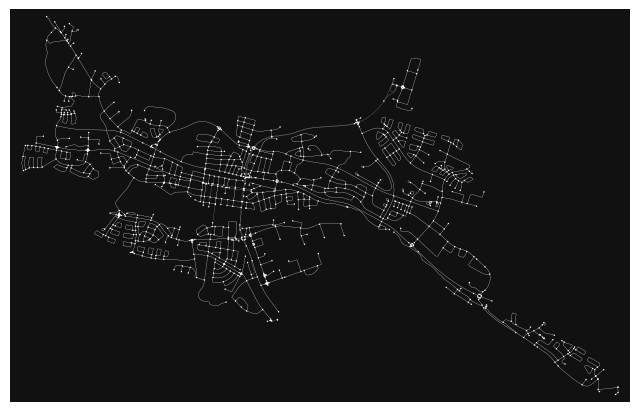

In [8]:
# Define the place name for Skellefteå Kommun
place_name = "Skellefteå, Västerbotten, Sweden"

# Download the road network for driving
G = ox.graph_from_place(place_name, network_type='drive')

# Plot the road network of Skellefteå
fig, ax = ox.plot_graph(G, node_size=1, edge_color='white', edge_linewidth=0.1)
plt.show()



                            highway  maxspeed
u      v          key                        
153674 354262     0           trunk        70
153676 1998727706 0           trunk        70
153679 262492434  0    unclassified        40
       250565428  0           trunk        50
       264508440  0     residential        30
153680 271092237  0           trunk  [70, 50]
       259412343  0           trunk        50
153681 153682     0           trunk        50
153682 330534651  0           trunk  [70, 50]
       266284268  0           trunk        50


IndexError: indices are out-of-bounds

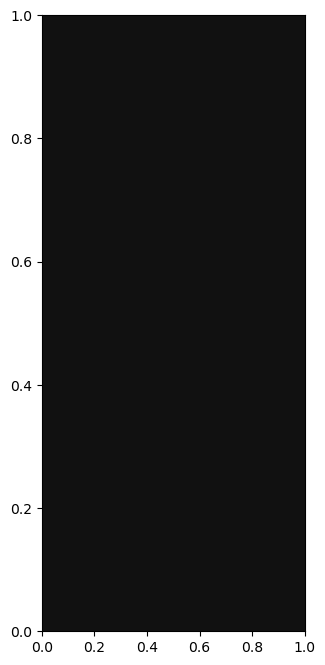

In [10]:
import osmnx as ox
import pandas as pd

# Step 1: Download the road network for Skellefteå
place_name = "Skellefteå, Västerbotten, Sweden"
G = ox.graph_from_place(place_name, network_type='drive')

# Step 2: Extract road segments (edges) with attributes
edges = ox.graph_to_gdfs(G, nodes=False)

# Step 3: Check for speed limit data
if 'maxspeed' in edges.columns:
    print(edges[['highway', 'maxspeed']].head(10))
else:
    print("No speed limit data available.")

# Step 4: Handle missing or inconsistent speed limit data
edges['maxspeed'] = edges['maxspeed'].fillna('50').astype(str)
edges['maxspeed'] = edges['maxspeed'].apply(lambda x: x.split(';')[0] if ';' in x else x)

# Step 5: Convert 'maxspeed' to numeric
def convert_speed(speed):
    try:
        return float(speed)
    except ValueError:
        return None  # If not numeric, return None

edges['maxspeed'] = edges['maxspeed'].apply(convert_speed)

# Step 6: Drop rows with missing speed limits
edges = edges.dropna(subset=['maxspeed'])

# Step 7: Visualize the road network with speed limits
fig, ax = ox.plot_graph(G, edge_color=edges['maxspeed'], edge_linewidth=1.5,  node_size=0)
